# Telecom Data Preprocessing Pipeline

This notebook processes telecom conversation data to create a multilingual dataset for RAG applications. The pipeline transforms ~60K English conversations into a balanced multilingual corpus across 4 languages.

## Pipeline Stages:
1. **Topic Filtering** - Select balanced samples from BERTopic-categorized conversations, prioritizing network and customer service issues
2. **Translation** - Batch translate conversations to German (DEU), French (FRA), and Italian (ITA) using Google Translate API
3. **Named Entity Recognition** - Clean sensitive information by replacing names, locations, and numbers with generic tokens (PER, LOC, NUM)
   - Technical Methods - Specifies BERTopic categorization
4. **Data Analysis** - Visualize final topic distribution and language balance for model training

**Output**: Clean, anonymized multilingual dataset ready for vector embedding and RAG system training.

In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telecom-conversations-after-topic-modeling/topics.csv
/kaggle/input/telecom-conversations-after-topic-modeling/aggregated_conversations_with_topicmodeling.csv
/kaggle/input/combined-after-translation-csv/combined_after_translation.csv
/kaggle/input/telecom-filtered-list/filtered_list.csv
/kaggle/input/telecom-after-ner/after_ner.csv
/kaggle/input/telecom/aggregated_conversations.csv
/kaggle/input/telecom-train-set/train_df.csv


In [3]:
import pandas as pd

In [4]:
df_corpus =pd.read_csv("/kaggle/input/telecom-conversations-after-topic-modeling/aggregated_conversations_with_topicmodeling.csv")
df_counts = pd.read_csv("/kaggle/input/telecom-conversations-after-topic-modeling/topics.csv")

In [5]:
df_counts.columns = ['Topic', 'count', 'count_to_filter', 'topic_label', 'Representation',
       'Representative_Docs']

In [6]:
df_counts.head()

,Topic,count,count_to_filter,topic_label,Representation,Representative_Docs
0,-1,99634,26171,-1_plan_data_account_agent,"['plan', 'data', 'account', 'agent', 'client',...","[""agent: Thank you for calling Union Mobile. M..."
1,0,11905,3127,0_devices_thermostat_smart_home,"['devices', 'thermostat', 'smart', 'home', 'ne...","[""agent: Good morning, thank you for calling U..."
2,1,5571,1463,1_repair_damage_claim_insurance,"['repair', 'damage', 'claim', 'insurance', 'po...","[""agent: Thank you for calling Union Mobile, m..."
3,2,5051,1326,2_international_trip_roaming_abroad,"['international', 'trip', 'roaming', 'abroad',...","[""agent: Hello! Welcome to Union Mobile. My na..."
4,3,4290,1126,3_health_wearable_fitness_smartwatch,"['health', 'wearable', 'fitness', 'smartwatch'...","['agent: Hello you for calling Union Mobile, m..."


In [7]:
print(df_counts['count_to_filter'].sum())

60000


In [8]:
print(df_counts['topic_label'].value_counts().sum())

307


In [9]:
df_corpus_topics = pd.DataFrame(df_corpus['topic_label'].value_counts()).reset_index()
df_corpus_topics.columns = ['topic_label', 'count']

In [10]:
# Normalize the count based on actual count to target number of records
df_corpus_topics['filter_count'] = df_corpus_topics['count'].apply(lambda x : int((x/df_corpus.shape[0])* 60000))

### Manually readjusting the filter count making sure most relevent topics good share of information

In [11]:
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '0_devices_thermostat_smart_home','filter_count'] = 400
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '9_identity_unable_verify_match','filter_count'] = 100
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '12_digits_identity_credit_verify','filter_count'] = 50
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '2_repair_damage_claim_insurance','filter_count'] = 50
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '4_health_fitness_wearable_smartwatch','filter_count'] = 40
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '10_headphones_earbuds_pair_wireless','filter_count'] = 40
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '16_camera_lens_lenses_cleaning','filter_count'] = 30


In [12]:
network_related_topics = [
    '6_10gb_plan_current_unlimited',
    '3_area_slow_speeds_network',
    '5_vpn_server_connect_connection',
    '13_hotspot_laptop_tethering_connecting',
    '39_streaming_buffering_video_stream',
    '103_usage_alerts_limit_monitor',
    '109_internet_router_home_modem',
    '25_wi_fi_public_network',
    '104_mode_safe_factory_freezing',
    '102_game_games_gaming_play',
    '42_charge_refund_dispute_charged',
    '90_sim_card_new_replacement',
    '69_sync_automatic_syncing_contacts',
    '1_international_trip_roaming_abroad',
    '17_roaming_international_abroad_sim',
    '79_charges_roaming_charged_abroad',
    '19_messaging_messages_app_sending',
    '34_payment_payments_pay_automatic',
    '169_business_lines_unlimited_employees',
    '18_usage_limit_data_videos'
]


df_corpus_topics.loc[df_corpus_topics['topic_label'].isin(network_related_topics)]

,topic_label,count,filter_count
1,1_international_trip_roaming_abroad,9822,2580
3,6_10gb_plan_current_unlimited,6765,1777
6,3_area_slow_speeds_network,5689,1494
7,18_usage_limit_data_videos,4854,1275
9,17_roaming_international_abroad_sim,3539,929
10,5_vpn_server_connect_connection,3482,914
16,13_hotspot_laptop_tethering_connecting,2499,656
19,39_streaming_buffering_video_stream,1861,488
20,42_charge_refund_dispute_charged,1855,487
24,19_messaging_messages_app_sending,1572,412


In [13]:
customer_related_network_issues = [
    '4_wifi_connection_problems',
    '31_cell_reception_quality',
    '32_network_outage_reports',
    '33_dropped_calls_frequent',
    '35_internet_speed_fluctuations',
    '36_wifi_hotspot_access_failures',
    '37_mobile_network_not_available',
    '38_data_plan_billing_errors',
    '40_network_equipment_failures',
    '41_customer_service_response_time',
    '43_voip_quality_issues',
    '44_signal_interference_problems',
    '45_network_synchronization_errors',
    '46_online_gaming_latency',
    '47_video_conferencing_disruptions',
    '48_social_media_connectivity_issues',
    '49_email_delivery_delays',
    '50_device_compatibility_with_network',
    '51_firmware_update_network_issues',
    '52_network_coverage_blind_spots'
]


df_corpus_topics.loc[df_corpus_topics['topic_label'].isin(customer_related_network_issues)]

,topic_label,count,filter_count


In [17]:
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '0_devices_thermostat_smart_home','filter_count'] = 400
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '9_identity_unable_verify_match','filter_count'] = 400
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '12_digits_identity_credit_verify','filter_count'] = 50
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '2_repair_damage_claim_insurance','filter_count'] = 50
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '4_health_fitness_wearable_smartwatch','filter_count'] = 40
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '10_headphones_earbuds_pair_wireless','filter_count'] = 40
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '16_camera_lens_lenses_cleaning','filter_count'] = 30

In [18]:
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '17_roaming_international_abroad_sim','filter_count'] = 1500
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '308_payment_recipient_transaction_sent','filter_count'] = 100
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '79_charges_roaming_charged_abroad','filter_count'] = 800
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '25_wi_fi_public_network','filter_count'] = 500
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '39_streaming_buffering_video_stream','filter_count'] = 800
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '109_internet_router_home_modem','filter_count'] = 800
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '103_usage_alerts_limit_monitor','filter_count'] = 600


df_corpus_topics.loc[df_corpus_topics['topic_label'] == '42_charge_refund_dispute_charged','filter_count'] = 800
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '13_hotspot_laptop_tethering_connecting','filter_count'] = 800
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '90_sim_card_new_replacement','filter_count'] = 500
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '69_sync_automatic_syncing_contacts','filter_count'] = 400
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '169_business_lines_unlimited_employees','filter_count'] = 800
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '19_messaging_messages_app_sending','filter_count'] = 600
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '34_payment_payments_pay_automatic','filter_count'] = 600
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '3_area_slow_speeds_network','filter_count'] = 3743
df_corpus_topics.loc[df_corpus_topics['topic_label'] == '18_usage_limit_data_videos','filter_count'] = 3000

In [21]:
 df_corpus_topics[df_corpus_topics['topic_label'] == '-1_plan_data_account_agent']

,topic_label,count,filter_count
17,-1_plan_data_account_agent,2410,633


In [22]:
df_merged = pd.merge(df_corpus, df_corpus_topics, on='topic_label', how='left')

# Check if there are any NaN values in 'count_to_filter' column and handle them
df_merged['filter_count'] = df_merged['filter_count'].fillna(0)
# Convert 'count_to_filter' to int to avoid type mismatch (optional, based on your data type)
df_merged['filter_count'] = df_merged['filter_count'].astype(int)

# Sort based on 'topic_label' to ensure proper grouping.
df_merged = df_merged.sort_values(by='topic_label')

# Use cumcount to create a sequential count for each topic label.
df_merged['cumcount'] = df_merged.groupby('topic_label').cumcount()

# Filter the records where cumcount is less than the count_to_filter.
# This will select the top N records for each topic label, where N is count_to_filter.
df_filtered = df_merged[df_merged['cumcount'] < df_merged['filter_count']]

# Drop the helper columns 'count_to_filter' and 'cumcount', as they are no longer needed.
df_filtered = df_filtered.drop(columns=['filter_count', 'cumcount'])

# Now df_filtered contains the records as per the specified counts in df_counts

In [23]:
df_filtered.shape

(59552, 4)

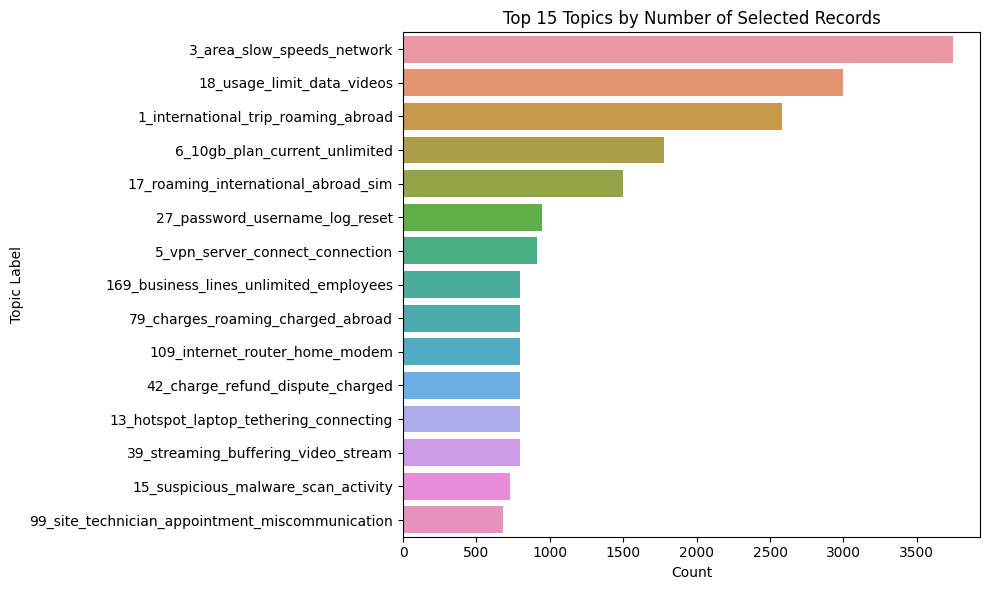

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top 15 topic labels by count
top_topics = df_filtered['topic_label'].value_counts().nlargest(15).index

# Filter df_filtered to include only the top 15 topics
df_top_filtered = df_filtered[df_filtered['topic_label'].isin(top_topics)]

# Plot the countplot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_filtered, y='topic_label', order=top_topics)

# Add title and labels
plt.title('Top 15 Topics by Number of Selected Records')
plt.xlabel('Count')
plt.ylabel('Topic Label')
plt.tight_layout()
plt.show()


In [25]:
df_filtered.head()

,conversation_id,text,topic_label,count
196207,c3838282f9cd46f7b18a8e502f47e262,"agent: Hello, thank you for calling Union Mobi...",-1_plan_data_account_agent,2410
101592,a791c220b2504cfcb1669e4f07f7c160,"agent: Good afternoon, thank you for calling U...",-1_plan_data_account_agent,2410
101594,1a0264d5a7e94cb8929829a5c1a97e85,"agent: Thank you for calling Union Mobile, my ...",-1_plan_data_account_agent,2410
80541,ff85ddd97ad3402bbdb1db7740f008e3,"agent: Good afternoon, thank you for calling U...",-1_plan_data_account_agent,2410
26599,13863e7b83394b7d8850ec4f7324fcb6,"agent: Hello, thank you for calling Union Mobi...",-1_plan_data_account_agent,2410


In [26]:
df_shuffled = df_filtered.sample(frac=1).reset_index(drop=True)

In [27]:
df_shuffled.head()

,conversation_id,text,topic_label,count
0,000857604cf5412e9e0cabe5dd392cce,"agent: Thank you for calling Union Mobile, my ...",224_cancel_cancellation_service_expensive,441
1,962ea94363aa4a799b18bd2902ffc67e,"agent: Thank you for calling Union Mobile, my ...",26_security_protect_encryption_measures,1836
2,5b0edabeeee544b2ab379be39a6ff685,"client: Hi, I'm calling to transfer my number ...",158_change_number_new_request,444
3,e1bcffda98df41fe80fbae02db10d587,"agent: Hello, thank you for calling Union Mobi...",27_password_username_log_reset,3617
4,ee1a23b67dd14809b1d606641207d59d,"agent: Hello, thank you for calling Union Mobi...",150_media_social_accounts_password,231


In [28]:
df_shuffled.to_csv("/kaggle/working/filtered_list.csv")

In [ ]:
import pandas as pd
df_shuffled = pd.read_csv("/kaggle/input/telecom-filtered-list/filtered_list.csv")

# GoogleTrans

In [ ]:
pip install googletrans

In [ ]:
from googletrans import Translator
import pandas as pd
import asyncio

# Define asynchronous translation function
async def translate_column(df, src_lang, dest_lang):
    translator = Translator(timeout=60)
    for index, row in df.iterrows():
        # Translate text asynchronously
        #if not (row['Translated_Text']):
        translated = await translator.translate(row['text'], src=src_lang, dest=dest_lang)
        df.at[index, 'Translated_Text'] = translated.text
    return df


In [ ]:
df_deu = df_shuffled.iloc[0:15001]
df_fra = df_shuffled.iloc[15001:30001]
df_ita = df_shuffled.iloc[30001:45001]
df_enu = df_shuffled.iloc[45001:]

In [ ]:
df_deu_1 = df_shuffled.iloc[0:2000]

# Second chunk from row 20001 to 25000
df_deu_2 = df_shuffled.iloc[2000:4000]

# Third chunk from row 25001 to 30000
df_deu_3 = df_shuffled.iloc[4000:6000]

df_deu_4 = df_shuffled.iloc[6000:8000]

df_deu_5 = df_shuffled.iloc[8000:10000]

df_deu_6 = df_shuffled.iloc[10000:12000]

df_deu_7 = df_shuffled.iloc[12000:14000]

df_deu_8 = df_shuffled.iloc[14000:15001]

In [ ]:
df_fra_1 = df_shuffled.iloc[15001:17000]

df_fra_2 = df_shuffled.iloc[17000:19000]

df_fra_3 = df_shuffled.iloc[19000:21000]

df_fra_4 = df_shuffled.iloc[21000:23000]

df_fra_5 = df_shuffled.iloc[23000:25000]

df_fra_6 = df_shuffled.iloc[25000:27000]

df_fra_7 = df_shuffled.iloc[27000:29000]

df_fra_8 = df_shuffled.iloc[29000:30001]

In [ ]:
df_ita_1 = df_shuffled.iloc[30001:32000]

df_ita_2 = df_shuffled.iloc[32000:34000]

df_ita_3 = df_shuffled.iloc[34000:36000]

df_ita_4 = df_shuffled.iloc[36000:38000]

df_ita_5 = df_shuffled.iloc[38000:40000]

df_ita_6 = df_shuffled.iloc[40000:42000]

df_ita_7 = df_shuffled.iloc[42000:44000]

df_ita_8 = df_shuffled.iloc[44000:45001]

In [ ]:
from googletrans import Translator
import pandas as pd
import asyncio

# Define asynchronous translation function
async def translate_column(df, src_lang, dest_lang):
    translator = Translator(timeout=100)
    total_records = len(df)
    processed_records = 0
    
    for index, row in df.iterrows():
        # Translate text asynchronously
        translated = await translator.translate(row['text'], src=src_lang, dest=dest_lang)
        df.at[index, 'Translated_Text'] = translated.text
        
        processed_records += 1
        if processed_records % 100 == 0:
            print(f"Processed {processed_records}/{total_records} records")
        
    print(f"Total {processed_records}/{total_records} records processed")
    return df



In [ ]:
df_deu_translated_1 = await translate_column(df_deu_1, src_lang='en', dest_lang='de')
print(df_deu_translated_1.head())
df_deu_translated_1.to_csv('/kaggle/working/output_deu_1.csv', index=False)

In [ ]:
df_deu_translated_2 = await translate_column(df_deu_2, src_lang='en', dest_lang='de')
print(df_deu_translated_2.head())
df_deu_translated_2.to_csv('/kaggle/working/output_deu_2.csv', index=False)

In [ ]:
df_deu_translated_3 = await translate_column(df_deu_3, src_lang='en', dest_lang='de')
print(df_deu_translated_3.head())
df_deu_translated_3.to_csv('/kaggle/working/output_deu_3.csv', index=False)

In [ ]:
df_deu_translated_4 = await translate_column(df_deu_4, src_lang='en', dest_lang='de')
df_deu_translated_4.to_csv('/kaggle/working/output_deu_4.csv', index=False)

In [ ]:
df_deu_translated_5 = await translate_column(df_deu_5, src_lang='en', dest_lang='de')

df_deu_translated_5.to_csv('/kaggle/working/output_deu_5.csv', index=False)

In [ ]:
df_deu_translated_6 = await translate_column(df_deu_6, src_lang='en', dest_lang='de')
print(df_deu_translated_6.head())
df_deu_translated_6.to_csv('/kaggle/working/output_deu_6.csv', index=False)

In [ ]:
df_deu_translated_7 = await translate_column(df_deu_7, src_lang='en', dest_lang='de')
print(df_deu_translated_7.head())
df_deu_translated_7.to_csv('/kaggle/working/output_deu_7.csv', index=False)

In [ ]:
df_deu_translated_8 = await translate_column(df_deu_8, src_lang='en', dest_lang='de')
print(df_deu_translated_8.head())
df_deu_translated_8.to_csv('/kaggle/working/output_deu_8.csv', index=False)

In [ ]:
df_fra_translated_1 = await translate_column(df_fra_1, src_lang='en', dest_lang='fr')
print(df_fra_translated_1.head())
df_fra_translated_1.to_csv('/kaggle/working/output_fra_1.csv', index=False)

In [ ]:
df_fra_translated_2 = await translate_column(df_fra_2, src_lang='en', dest_lang='fr')
print(df_fra_translated_2.head())
df_fra_translated_2.to_csv('/kaggle/working/output_fra_2.csv', index=False)

In [ ]:
df_fra_translated_3 = await translate_column(df_fra_3, src_lang='en', dest_lang='fr')
print(df_fra_translated_3.head())
df_fra_translated_3.to_csv('/kaggle/working/output_fra_3.csv', index=False)

In [ ]:
df_fra_translated_4 = await translate_column(df_fra_4, src_lang='en', dest_lang='fr')
df_fra_translated_4.to_csv('/kaggle/working/output_fra_4.csv', index=False)

In [ ]:
df_fra_translated_5 = await translate_column(df_fra_5, src_lang='en', dest_lang='fr')

df_fra_translated_5.to_csv('/kaggle/working/output_fra_5.csv', index=False)

In [ ]:
df_fra_translated_6 = await translate_column(df_fra_6, src_lang='en', dest_lang='fr')
print(df_fra_translated_6.head())
df_fra_translated_6.to_csv('/kaggle/working/output_fra_6.csv', index=False)

In [ ]:
df_fra_translated_7 = await translate_column(df_fra_7, src_lang='en', dest_lang='fr')
print(df_fra_translated_7.head())
df_fra_translated_7.to_csv('/kaggle/working/output_fra_7.csv', index=False)

In [ ]:
df_fra_translated_8 = await translate_column(df_fra_8, src_lang='en', dest_lang='fr')
print(df_fra_translated_8.head())
df_fra_translated_8.to_csv('/kaggle/working/output_fra_8.csv', index=False)

In [ ]:
df_ita_translated_1 = await translate_column(df_ita_1, src_lang='en', dest_lang='it')
print(df_ita_translated_1.head())
df_ita_translated_1.to_csv('/kaggle/working/output_ita_1.csv', index=False)

In [ ]:
df_ita_translated_2 = await translate_column(df_ita_2, src_lang='en', dest_lang='it')
print(df_ita_translated_2.head())
df_ita_translated_2.to_csv('/kaggle/working/output_ita_2.csv', index=False)

In [ ]:
df_ita_translated_3 = await translate_column(df_ita_3, src_lang='en', dest_lang='it')
print(df_ita_translated_3.head())
df_ita_translated_3.to_csv('/kaggle/working/output_ita_3.csv', index=False)

In [ ]:
df_ita_translated_4 = await translate_column(df_ita_4, src_lang='en', dest_lang='it')
df_ita_translated_4.to_csv('/kaggle/working/output_ita_4.csv', index=False)

In [ ]:
df_ita_translated_5 = await translate_column(df_ita_5, src_lang='en', dest_lang='it')

df_ita_translated_5.to_csv('/kaggle/working/output_ita_5.csv', index=False)

In [ ]:
df_ita_translated_6 = await translate_column(df_ita_6, src_lang='en', dest_lang='it')
print(df_ita_translated_6.head())
df_ita_translated_6.to_csv('/kaggle/working/output_ita_6.csv', index=False)

In [ ]:
df_ita_translated_7 = await translate_column(df_ita_7, src_lang='en', dest_lang='it')
print(df_ita_translated_7.head())
df_ita_translated_7.to_csv('/kaggle/working/output_ita_7.csv', index=False)

In [ ]:
df_ita_translated_8 = await translate_column(df_ita_8, src_lang='en', dest_lang='it')
print(df_ita_translated_8.head())
df_ita_translated_8.to_csv('/kaggle/working/output_ita_8.csv', index=False)

# Named entity recognition

In [ ]:
import pandas as pd
import os

# Assuming all CSV files are in the current working directory
directory = os.getcwd()

# Create an empty DataFrame to hold all the concatenated data
master_df = pd.DataFrame()

# List of prefixes for the types of files
prefixes = ['deu', 'fra', 'ita']

# Loop over the prefixes and numbers to read and concatenate the files
for prefix in prefixes:
    for i in range(1, 9): # Assuming the file numbers range from 1 to 8
        # Construct the file name
        file_name = f'self/output_{prefix}_{i}.csv'
        # Construct the full file path
        file_path = os.path.join(directory, file_name)
        # Check if the file exists
        if os.path.isfile(file_path):
            # Read the current CSV file
            current_df = pd.read_csv(file_path)
            # Select only the relevant columns if there are more than the specified columns
            current_df = current_df[['conversation_id', 'topic_label', 'Translated_Text']]
            # Append the current DataFrame to the master DataFrame
            master_df = pd.concat([master_df, current_df], ignore_index=True)
            
df_filtered_list = pd.read_csv("/kaggle/input/telecom-filtered-list/filtered_list.csv")

df_enu = df_filtered_list[45001:].rename(columns={'text': 'Translated_Text'})

df_enu = df_enu[['conversation_id', 'topic_label', 'Translated_Text']]

master_df = pd.concat([master_df, df_enu], ignore_index=True)


# After the loop, master_df will contain all the data concatenated
# You could check the combined dataframe structure
print(master_df.head())

# You can now use master_df for further analysis or save to a new CSV file
master_df.to_csv('/kaggle/working/output_combined.csv', index=False)


In [ ]:
!pip install swifter
!pip install --upgrade huggingface_hub
!pip install transformers
!pip install datasets==2.16.0

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import re

tokenizer = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner", local_files_only=False)
model = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner", local_files_only=False)

nlp = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)



# Compile the regex pattern to replace numbers
number_pattern = re.compile(r'\d+(\.\d+)?')

# Define the cleaning function
def clean_text(text):
    
    # Run NER model once for each example
    ner_results = nlp(text)
    
    # Replace detected person and location entities
    for entity in ner_results:
        if entity['entity_group'] == 'PER':
            text = text.replace(entity['word'], 'PER')
        elif entity['entity_group'] == 'LOC':
            text = text.replace(entity['word'], 'LOC')
    
    # Replace all other numbers (excluding the customer care number)
    text = number_pattern.sub('NUM', text)
    return text

In [ ]:
data= pd.read_csv("/kaggle/input/combined-after-translation-csv/combined_after_translation.csv")

In [ ]:
from datetime import datetime
import swifter

start_time = datetime.now()
print(f"Start Time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

data['cleaned_text'] = data['Translated_Text'].swifter.apply(clean_text)

finish_time = datetime.now()
print(f"\nFinish Time: {finish_time.strftime('%Y-%m-%d %H:%M:%S')}")

# Calculate total processing time
processing_time = finish_time - start_time
print(f"Total Processing Time: {processing_time}")

In [29]:
data.to_csv("/kaggle/working/after_ner.csv",index=False)

NameError: name 'data' is not defined

In [49]:
df_after_ner = pd.read_csv("/kaggle/input/telecom-after-ner/after_ner.csv")

df_after_ner.head()

,conversation_id,topic_label,Translated_Text,cleaned_text
0,061c4d3f5b0d4bdcac7ccd4fae2cb8f0,6_10gb_plan_current_unlimited,"Agent: Danke, dass Sie Union Mobile angerufen ...","Agent: Danke, dass Sie Union Mobile angerufen ..."
1,5b7cd638d0644aa29b6f3b77e3318408,30_upgrade_camera_powerful_interested,"Agent: Hallo, vielen Dank, dass Sie sich an Un...","Agent: Hallo, vielen Dank, dass Sie sich an Un..."
2,3ce46dbc98b0473599b789a72d5bde0a,3_area_slow_speeds_network,"Agent: Hallo, danke, dass du Union Mobile ange...","Agent: Hallo, danke, dass du Union Mobile ange..."
3,990807d235434aa0a6dbbc7712c4dbd9,262_energy_thermostat_bills_temperature,"Agent: Hallo, danke, dass du Union Mobile ange...","Agent: Hallo, danke, dass du Union Mobile ange..."
4,456346e40db3452ca97dd120b0a12df2,240_collaboration_tools_conferencing_video,"Agent: Hallo, danke, dass du Union Mobile ange...","Agent: Hallo, danke, dass du Union Mobile ange..."


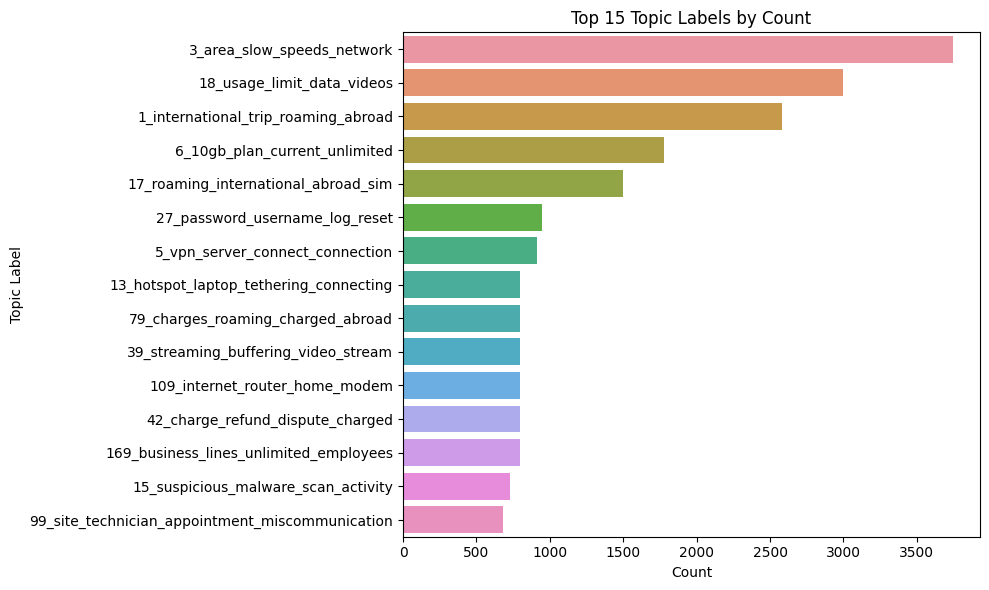

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# Get top 15 categories by count
top_15 = df_after_ner['topic_label'].value_counts().nlargest(15).index

# Filter the dataframe for only those top 15
filtered_df = df_after_ner[df_after_ner['topic_label'].isin(top_15)]

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df, y='topic_label', order=filtered_df['topic_label'].value_counts().index)
plt.title("Top 15 Topic Labels by Count")
plt.xlabel("Count")
plt.ylabel("Topic Label")
plt.tight_layout()
plt.show()


In [33]:
df_after_ner = pd.read_csv("/kaggle/input/telecom-after-ner/after_ner.csv")

df_after_ner.head()

,conversation_id,topic_label,Translated_Text,cleaned_text
0,061c4d3f5b0d4bdcac7ccd4fae2cb8f0,6_10gb_plan_current_unlimited,"Agent: Danke, dass Sie Union Mobile angerufen ...","Agent: Danke, dass Sie Union Mobile angerufen ..."
1,5b7cd638d0644aa29b6f3b77e3318408,30_upgrade_camera_powerful_interested,"Agent: Hallo, vielen Dank, dass Sie sich an Un...","Agent: Hallo, vielen Dank, dass Sie sich an Un..."
2,3ce46dbc98b0473599b789a72d5bde0a,3_area_slow_speeds_network,"Agent: Hallo, danke, dass du Union Mobile ange...","Agent: Hallo, danke, dass du Union Mobile ange..."
3,990807d235434aa0a6dbbc7712c4dbd9,262_energy_thermostat_bills_temperature,"Agent: Hallo, danke, dass du Union Mobile ange...","Agent: Hallo, danke, dass du Union Mobile ange..."
4,456346e40db3452ca97dd120b0a12df2,240_collaboration_tools_conferencing_video,"Agent: Hallo, danke, dass du Union Mobile ange...","Agent: Hallo, danke, dass du Union Mobile ange..."


In [45]:
df_train = pd.read_csv("/kaggle/input/telecom-train-set/train_df.csv")
df_test = pd.read_csv("/kaggle/input/telecom-test-data/test_df.csv")

In [39]:
# Group by 'topic_label' and 'language', count records
count_comparison = df_train.groupby(['topic_label', 'language']).size().unstack(fill_value=0)

# Add a total count column and sort by it
count_comparison['total'] = count_comparison.sum(axis=1)
top_15 = count_comparison.sort_values(by='total', ascending=False).head(15)

# Drop the total column if only language-wise counts are needed
top_15 = top_15.drop(columns='total')

# Display the top 15 topic records
top_15


language,deu,eng,fra,ita
topic_label,,,,
3_area_slow_speeds_network,633,597,637,639
18_usage_limit_data_videos,523,519,497,487
1_international_trip_roaming_abroad,428,417,429,411
6_10gb_plan_current_unlimited,295,302,297,262
17_roaming_international_abroad_sim,253,248,250,242
27_password_username_log_reset,151,176,140,173
5_vpn_server_connect_connection,155,144,148,137
79_charges_roaming_charged_abroad,144,140,136,136
42_charge_refund_dispute_charged,138,112,155,133


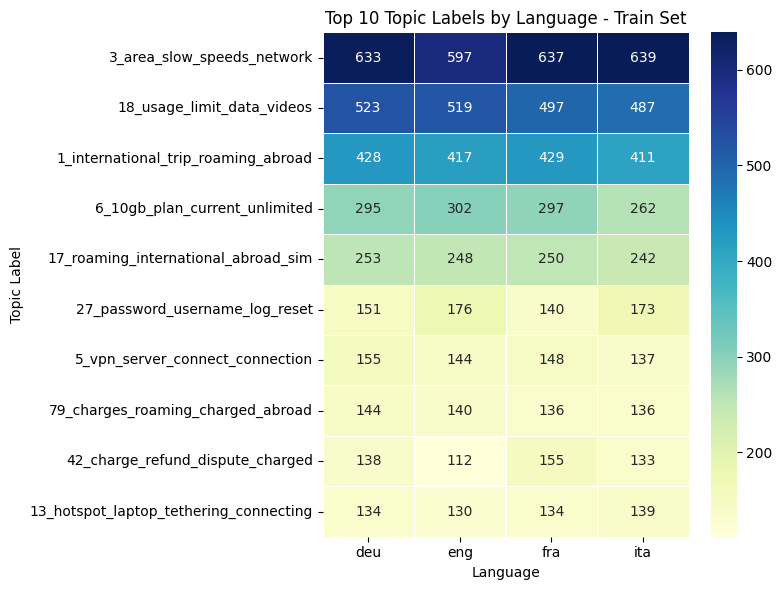

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by 'topic_label' and 'language', count records
count_comparison = df_train.groupby(['topic_label', 'language']).size().unstack(fill_value=0)

# Add total count column and get top 10 by total
count_comparison['total'] = count_comparison.sum(axis=1)
top_10 = count_comparison.sort_values(by='total', ascending=False).head(10)
top_10 = top_10.drop(columns='total')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(top_10, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5)
plt.title("Top 10 Topic Labels by Language - Train Set")
plt.ylabel("Topic Label")
plt.xlabel("Language")
plt.tight_layout()
plt.show()


In [46]:
# Group by 'topic_label' and 'language', count records
count_comparison = df_test.groupby(['topic_label', 'language']).size().unstack(fill_value=0)

# Add a total count column and sort by it
count_comparison['total'] = count_comparison.sum(axis=1)
top_15 = count_comparison.sort_values(by='total', ascending=False).head(15)

# Drop the total column if only language-wise counts are needed
top_15 = top_15.drop(columns='total')

# Display the top 15 topic records
top_15

language,deu,eng,fra,ita
topic_label,,,,
3_area_slow_speeds_network,3,7,7,7
18_usage_limit_data_videos,4,4,8,8
17_roaming_international_abroad_sim,2,4,1,7
1_international_trip_roaming_abroad,6,0,3,5
6_10gb_plan_current_unlimited,3,3,4,1
39_streaming_buffering_video_stream,2,4,1,0
55_coverage_cancellation_cancel_area,3,3,0,1
5_vpn_server_connect_connection,3,2,0,2
90_sim_card_new_replacement,2,1,4,0


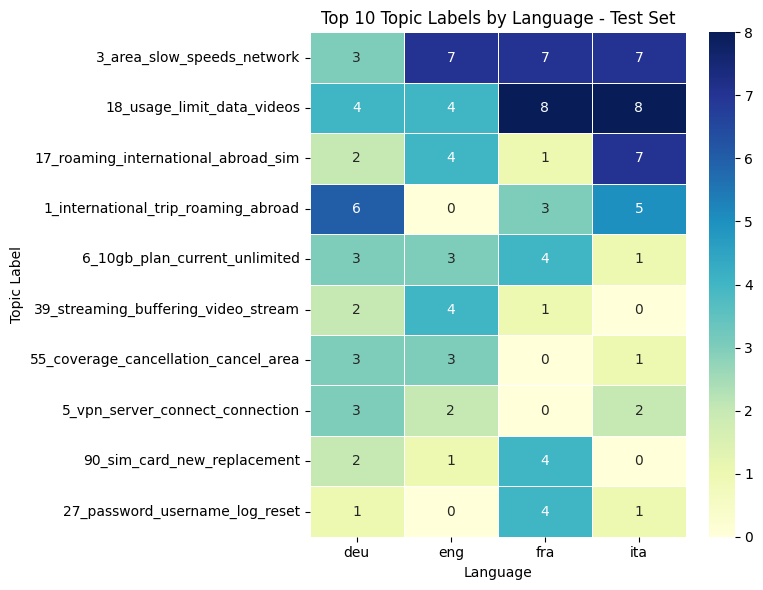

In [48]:
# Group by 'topic_label' and 'language', count records
count_comparison = df_test.groupby(['topic_label', 'language']).size().unstack(fill_value=0)

# Add total count column and get top 10 by total
count_comparison['total'] = count_comparison.sum(axis=1)
top_10 = count_comparison.sort_values(by='total', ascending=False).head(10)
top_10 = top_10.drop(columns='total')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(top_10, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5)
plt.title("Top 10 Topic Labels by Language - Test Set")
plt.ylabel("Topic Label")
plt.xlabel("Language")
plt.tight_layout()
plt.show()